In [3]:
import sys
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
sys.path.append("../Modules/")
import helper

In [85]:
class TextNorm(helper.Normalize):
    """Map a list of text values to the float range 0-1"""

    def __init__(self, textvals, clip=False):
        self._clip = clip
        # if you want, clean text here, for duplicate, sorting, etc
        ltextvals = set(textvals)
        self.N = len(ltextvals)
        self.textmap = dict(
            [(text, float(i)/(self.N-1)) for i, text in enumerate(ltextvals)])
        self._vmin = 0
        self._vmax = 1

    def __call__(self, x, clip=None):
        ret = helper.ma.asarray([self.textmap.get(xkey, -1) for xkey in x])
        return ret

    def inverse(self, value):
        return ValueError("TextNorm is not invertible")

In [86]:
is_demo = True

In [87]:
class XForce_Grapher():
    def __init__(self) -> None:
        self._data = None
        self._sources = None
        self._queries = None
        self._summary = None
        self._nlp_summary = None
        self._data_size = None
        self._sparse_matrix = None
        self._sparse_matrix_names = None
        self.load("../../data/complete_db.csv")
        return None

    def load(self, path: str) -> None:
        self.load_db(path)
        self.load_db_summary()
        self.load_nlp_summary()
        return None

    def load_db(self, path: str) -> None:
        """ 
        # TODO DOCUMENTATION
        """
        df = helper.pd.read_csv(path)
        sources = list(set(df["source"].values.tolist()))
        sources.append("ALL")
        queries = list(set(df["query"].values.tolist()))
        queries.append("ALL")

        self._data = df
        self._data_size = len(df)
        self._sources = sources
        self._queries = queries
        return None

    def load_db_summary(self) -> None:
        """
        Generates the report table of the count of paper entries by query and by source and stores it in class attribute.

        Returns -> None
            Stores the report dataframe into class attribute.

        Example
            grapher = XForce_Grapher()
            grapher.load_db_summary()
        """
        df = self._data.copy()
        sources = self._sources.copy()
        queries = self._queries.copy()
        l = [["source"], queries]
        data_header = [item for sublist in l for item in sublist]
        data_rows = []
        for source in sources:
            data_row = [source]
            if source == "ALL":
                filtered_by_source_df = df
            else:
                filtered_by_source_df = df[df["source"] == source]
            for query in queries:
                filtered_by_query_df = filtered_by_source_df[filtered_by_source_df["query"] == query]
                data_row.append(len(filtered_by_query_df))
            data_rows.append(data_row)
        report = helper.pd.DataFrame(data=data_rows, columns=data_header).iloc[:, :-1]
        self._summary = report
        return None

    def load_nlp_summary(self) -> None:
        """
        Creates, pre-processes, and saves the NLP summary report in class variable, which is ready for analytics.

        Returns -> None
            Saves the NLP summary report.
        
        Example
            grapher = XForce_Grapher()
            grapher.load_nlp_summary()
        """
        # Demo check
        if is_demo:
            print("Dynamic load disabled in demo mode due to 11hr+ runtime. All functions are ran on database snapshot.")
            print("If you load a different dataset, that data will not be reflected in NLP-based graphs.")
            self._nlp_summary = helper.pd.read_csv("../../data/demo_db.csv")
        else:
            # Filtering
            df = self._data.copy()
            df = df[["source", "query", "published", "url", "title", "abstract"]]
            
            # Cleaning & Feature Creation
            df.dropna(inplace=True)
            col_to_process = ["title", "abstract"]
            for col in col_to_process:
                df[f"{col}_char_count"] = df.loc[:, f"{col}"].map(lambda x: len(x))
                df[f"{col}_word_count"] = df.loc[:, f"{col}"].map(lambda x: len(x.split(" ")))
                print(f"Finished {col} counter; moving to rules-preprocessing.")
                df.loc[:, col] = df.loc[:, col].apply(lambda x: x.lower())
                df.loc[:, col] = df.loc[:, col].apply(lambda x: self.helper_remove_stopwords(x))
                df.loc[:, col] = df.loc[:, col].apply(lambda x: helper.re.sub('[%s]' % helper.re.escape(helper.string.punctuation), ' ' , x))
                df.loc[:, col] = df.loc[:, col].apply(lambda x: helper.re.sub(r'\d+', '', x))
                df.loc[:, col] = df.loc[:, col].apply(lambda x: helper.re.sub(' +', ' ', x))
                df.loc[:, col] = df.loc[:, col].apply(lambda x: self.helper_lemmatizer(x))
                print(f"Finished {col} rules-preprocessing; moving to singularization-preprocessing.")
                df.loc[:, col] = df.loc[:, col].apply(lambda x: self.helper_singularizer(x))
                print(f"Finished {col} singularization-preprocessing; moving to embedded-preprocessing.")
                df[f"{col}_keywords"] = df.loc[:, f"{col}"].map(lambda x: self.helper_keyword_extractor(x))
                print(f"Finished {col} embedded-preprocessing.")

            # Saving
            self._nlp_summary = df
        
        # Return
        return None

    def peek_data(self):
        return self._data.head()
    
    def get_data(self):
        return self._data

    def get_sources(self):
        return self._sources

    def get_queries(self):
        return self._queries
    
    def get_summary(self):
        return self._summary

    def peek_nlp_summary(self):
        if self._nlp_summary is not None:
            return self._nlp_summary.sort_values(by="abstract_word_count").reset_index().iloc[helper.np.r_[0:5, -5:0]]
        else:
            print("Please run .load_nlp_summary() first.")
            return None

    def get_nlp_summary(self):
        if self._nlp_summary is not None:
            return self._nlp_summary
        else:
            print("Please run .load_nlp_summary() first.")
            return None

    def set_data(self, path: str) -> None:
        self.load(path)
        return None

    def report_db_summary(self) -> None:
        """ 
        Prints a report table of the count of paper entries by query and by source.

        Returns -> None
            Both prints and returns the report dataframe.

        Example
            grapher = XForce_Grapher()
            grapher.report_db_summary()
        """
        print(self._summary)
        return None

    def graph_db_summary(self) -> None:
        """
        Graphs the report summary as a stacked barchart.

        Returns -> None
            Prints out matplotlib graph of the report summary
        
        Example
            grapher = XForce_Grapher()
            grapher.graph_db_summary()
        """
        df = self._summary.copy()
        extract_counts = df.T.values.tolist()[1:-1] # -1 to remove the "ALL" from the category
        extract_queries = df.T.index.tolist()[1:-1]
        sources = df["source"]

        query_count_data = {}
        for i in range(len(extract_counts)):
            query_count_data[extract_queries[i]] = extract_counts[i]
        
        width = 0.5
        fig, ax = helper.plt.subplots()
        bottom = helper.np.zeros(3)

        for query, count in query_count_data.items():
            p = ax.bar(sources, count, width, label=query, bottom=bottom)
            bottom += count

        helper.plt.title(f"Distribution of {self._data_size} Articles")
        helper.plt.xlabel("Source")
        helper.plt.ylabel("Counts")
        helper.plt.grid("True")
        helper.plt.legend(loc='upper left', bbox_to_anchor=(1,1))
        helper.plt.tight_layout()
        helper.plt.savefig(f"../../images/db_summ/db_summ.png")
        helper.plt.show()

        return "../../images/db_summ/db_summ.png"

    def graph_pub_freq(self, 
                       queries: list=["ALL"], 
                       sources: list=["ALL"],
                       country_mode: int=1) -> None:
        """
        # TODO Fix scopus date. Do not you run "ALL" for sources.
        # TODO Add country_mode

        Graphs the publishing frequency of papers in the database.

        queries -> list
            The given list of search queries (can be a 1-item list) that match database queries
            ALL: Considers all queries

        sources -> list
            The given list of search sources (can be a 1-item list) that match database sources
            ALL: Considers all sources

        country_mode -> int
            0: graphs the bars of the bar chart as normal bars
            1: graphs the bars of the bar chart as stacked bar charts corresponding to country of publishing institution

        Returns -> None
            Shows matplotlib graph of the published frequency
        
        Example
            grapher = XForce_Grapher()
            grapher.graph_pub_freq(["ALL"], ["ALL"], 1)
        """
        # Input Error Handling
        country_mode_options = {0,1}
        if country_mode not in country_mode_options:
            print(f"{country_mode} invalid, must be {country_mode_options}")
            return None

        for source in sources:
            if source not in self._sources:
                raise ValueError(f"{source} invalid, must be {self._sources}")
        
        for query in queries:
            if query not in self._queries:
                raise ValueError(f"{query} invalid, must be {self._queries}")

        # Load Data
        df = self._data.copy()
        
        # Filter Data
        title_sources, title_queries = ["ALL"], ["ALL"]
        if "ALL" not in sources:
            expression = helper.generate_boolean_conditions("source", sources)
            df = df[eval(expression)]
            title_sources = sources
        if "ALL" not in queries:
            expression = helper.generate_boolean_conditions("query", queries)
            df = df[eval(expression)]
            title_queries = queries
        
        # Data Setup
        dates_extract = df["published"].apply(lambda x: x.split('T')[0])
        dates = [helper.datetime(int(i.split("-")[0]), int(i.split("-")[1]), int(i.split("-")[2])) for i in dates_extract]
        
        # Graph
        helper.plt.title(f"Source: {title_sources}, Query: {title_queries}", fontsize=3)
        helper.plt.suptitle(f"Publish Frequency within {len(dates)} Most Recent Papers")
        helper.plt.xlabel("Publish Dates")
        helper.plt.ylabel("Frequency")
        helper.plt.grid("True")
        helper.plt.xticks(rotation=45)
        helper.plt.hist(dates, 25, alpha=.75)
        helper.plt.tight_layout()
        helper.plt.savefig(f"../../images/pub_freq/pub_freq_{'_'.join(title_sources)}_{'_'.join(title_queries)}.png")
        helper.plt.show()

        # Return
        return f"../../images/pub_freq/pub_freq_{'_'.join(title_sources)}_{'_'.join(title_queries)}.png"
 
    def graph_text_freq(self, 
                         queries: list=["ALL"], 
                         sources: list=["ALL"], 
                         text_mode: str="word", 
                         type_mode: str="abstract") -> None:
        """
        Graphs the text frequency (eg. character/word count of title/abstract) of indicated papers

        queries -> list
            The given list of search queries (can be a 1-item list) that match database queries
            ALL: Considers all queries

        sources -> list
            The given list of search sources (can be a 1-item list) that match database sources
            ALL: Considers all sources

        text_mode -> str
            Given type mode to filter on
            "char": Graphs via character count
            "word": Graphs via word count

        type_mode -> str
            Given type mode to filter on
            "title": Graphs on title
            "abstract": Graphs on abstract

        Returns -> None
            Shows matplotlib graph of the text counts
        
        Example
            grapher = XForce_Grapher()
            grapher.graph_text_freq(queries=["radiation", "plasmonics"], source=["arxiv"], text_mode="word", type_mode="abstract")
        """
        # Input Error Handling
        for source in sources:
            if source not in self._sources:
                raise ValueError(f"{source} invalid, must be {self._sources}")
        
        for query in queries:
            if query not in self._queries:
                raise ValueError(f"{query} invalid, must be {self._queries}")

        text_mode_options = {"char", "word"}
        if text_mode not in text_mode_options:
            raise ValueError(f"{text_mode} invalid; must be {text_mode_options}")

        type_mode_options = {"title", "abstract"}
        if type_mode not in type_mode_options:
            raise ValueError(f"{type_mode} invalid; must be {type_mode_options}")

        # Load Data
        if self._nlp_summary is None:
            print("Please run .load_nlp_summary() first, ETA ~1 minute.")
            return
        df = self._nlp_summary.copy()
        
        # Filter Data
        title_sources, title_queries = ["ALL"], ["ALL"]
        if "ALL" not in sources:
            expression = helper.generate_boolean_conditions("source", sources)
            df = df[eval(expression)]
            title_sources = sources
        if "ALL" not in queries:
            expression = helper.generate_boolean_conditions("query", queries)
            df = df[eval(expression)]
            title_queries = queries
        else:
            queries = self._queries[:-1]

        # Data Setup
        expression = f"{type_mode}_{text_mode}_count"
        graph_data = []
        for query in queries:
            graph_data.append(df[df["query"] == query][expression])

        # Graphing
        helper.plt.title(f"Source: {title_sources}, Query: {title_queries}")
        helper.plt.suptitle(f"Summary Statistics of {type_mode.title()} {text_mode.title()} Count by Specified Papers")
        helper.plt.xlabel("Query")
        helper.plt.ylabel("Count")
        helper.plt.grid("True")
        helper.plt.xticks(rotation=45)
        helper.plt.boxplot(graph_data, positions=helper.np.array(range(len(graph_data)))*2.0, sym='', widths=1.5)
        helper.plt.xticks(range(0, len(queries)*2, 2), queries, rotation=45)
        helper.plt.tight_layout()
        helper.plt.savefig(f"../../images/text_freq/text_freq_{'_'.join(title_sources)}_{'_'.join(title_queries)}.png")
        helper.plt.show()

        return f"../../images/text_freq/text_freq_{'_'.join(title_sources)}_{'_'.join(title_queries)}.png"

    def helper_remove_stopwords(self, input):
        """
        # TODO fill in docstring
        """
        words = input.split(" ")
        filtered_words = [word for word in words if word not in helper.MASTER_STOP_WORDS]
        output = " ".join(filtered_words)
        return output
    
    def helper_lemmatizer(self, input):
        """
        # TODO fill in docstring
        """
        wordnet_lemmatizer = helper.WordNetLemmatizer()
        words = input.split(" ")
        lemma_words = [wordnet_lemmatizer.lemmatize(word) for word in words]
        output = " ".join(lemma_words)
        return output
    
    def helper_keyword_extractor(self, input):
        """
        # TODO fill in docstring
        """
        kw_model = helper.KeyBERT()
        output = kw_model.extract_keywords(input, keyphrase_ngram_range=(1, 2), stop_words=helper.MASTER_STOP_WORDS)
        return output

    def helper_singularizer(self, input):
        """
        # TODO fill in docstring
        """
        blob = helper.TextBlob(input)
        singular_nouns = [word.singularize() for word, tag in blob.tags if tag.startswith('NN')]
        output = " ".join(singular_nouns)
        return output

    def helper_eval(self, input):
        output = eval(input)
        return output

    def helper_extract_text(self, input):
        input = eval(input)
        output = [i[0] for i in input]
        return output
    
    def helper_extract_value(self, input):
        input = eval(input)
        output = [i[1] for i in input]
        return output
    
    def helper_extract_set(self, input):
        output = set()
        for i in input:
            tokens = i.split(" ")
            for token in tokens:
                output.add(token)
        return list(output)

    def graph_keyword_freq(self, 
                           queries: list=["ALL"], 
                           sources: list=["ALL"], 
                           type_mode: str="abstract", 
                           k: int=15, 
                           n_gram: int=2) -> None:
        """
        # TODO Currently works with demo_db.csv 

        Graphs the keyword frequency of the specified papers. 

        queries -> list
            The given list of search queries (can be a 1-item list) that match database queries
            ALL: Considers all queries

        sources -> list
            The given list of search sources (can be a 1-item list) that match database sources
            ALL: Considers all sources

        type_mode -> str
            Given type mode to filter on
            "title": Graphs on title
            "abstract": Graphs on abstract

        k -> int
            The number of top n-grams to be graphed

        n_gram -> int
            The n-grams to graph on

        Returns -> None
            Shows matplotlib graph of the text counts
        
        Example
            grapher = XForce_Grapher()
            grapher.graph_text_count(queries=["radiation", "plasmonics"], source="arxiv", type_mode="abstract", k=15, n_grams=1)
        """
        # Input Error Handling
        for source in sources:
            if source not in self._sources:
                raise ValueError(f"{source} invalid, must be {self._sources}")
        
        for query in queries:
            if query not in self._queries:
                raise ValueError(f"{query} invalid, must be {self._queries}")

        type_mode_options = {"title", "abstract"}
        if type_mode not in type_mode_options:
            raise ValueError(f"{type_mode} invalid; must be {type_mode_options}")

        # Load Data
        if self._nlp_summary is None:
            print("Please run .load_nlp_summary() first, ETA ~1 minute.")
            return
        df = self._nlp_summary.copy()
        print("Running .graph_keyword_freq(), ETA ~1.5 minutes.")

        # Filter Data
        title_sources, title_queries = ["ALL"], ["ALL"]
        if "ALL" not in sources:
            expression = helper.generate_boolean_conditions("source", sources)
            df = df[eval(expression)]
            title_sources = sources
        if "ALL" not in queries:
            expression = helper.generate_boolean_conditions("query", queries)
            df = df[eval(expression)]
            title_queries = queries
        else:
            queries = self._queries[:-1]
        df[f"{type_mode}_keywords"] = df[f"{type_mode}_keywords"].apply(lambda x: self.helper_eval(x))
        keywords = df[f"{type_mode}_keywords"]
        keyword_freq = {}
        for list_of_keyword_tuples in keywords:
            for keyword_tuple in list_of_keyword_tuples:
                if len(keyword_tuple[0].split(" ")) == n_gram:
                    if keyword_tuple[0] in keyword_freq.keys():
                        keyword_freq[keyword_tuple[0]] += 1
                    else:
                        keyword_freq[keyword_tuple[0]] = 1
        keyword_list = [(k, v) for k, v in keyword_freq.items()]
        keyword_list.sort(key=lambda x: x[1], reverse=True)
        keyword_names = [i[0] for i in keyword_list[:k]]
        keyword_counts = [i[1] for i in keyword_list[:k]]
        
        # X = df.loc[:, type_mode] OLD METHOD
        # NLP Cleaning OLD
        # cvec = helper.CountVectorizer(ngram_range=(n_gram, n_gram))
        # sparse = cvec.fit_transform(X)
        # self._sparse_matrix = sparse
        # names = cvec.get_feature_names_out()
        # self._sparse_matrix_names = names
        # ngram_counts = sparse.sum(axis=0).A1

        # Data Setup OLD
        # df = helper.pd.DataFrame(data=[ngram_counts], index=["counts"], columns=names)
        # df = df.sort_values(by=df.index[0], axis=1, ascending=False)

        # Graphing
        helper.plt.title(f"Source: {title_sources}, Query: {title_queries}")
        helper.plt.suptitle(f"Top {k} Most Common {n_gram}-Grams in Papers from Given Queries")
        helper.plt.xlabel("Count")
        helper.plt.ylabel("Tokens")
        helper.plt.grid(True)
        helper.plt.barh(keyword_names[::-1], keyword_counts[::-1], alpha=0.5)

        # Saving
        helper.plt.tight_layout()
        helper.plt.savefig(f"../../images/keyword_freq/keyword_freq_{'_'.join(title_sources)}_{'_'.join(title_queries)}.png")
        helper.plt.show()

        return f"../../images/keyword_freq/keyword_freq_{'_'.join(title_sources)}_{'_'.join(title_queries)}.png"

    def graph_network_cooccurence(self, n: int=50, annotation_threshold: float=0.05) -> None:
        """
        # TODO: currently only works with demo_db.csv loaded due to eval inconsistency
        # n = number of top keywords per query
        # annotation_threshold = 0-1, any nodes of frequency count larger than threshold will be labeled
        """
        # -----------------------
        # DATA SETUP GRAPHING
        # -----------------------
        # Error Handling
        if self._nlp_summary is None:
            print("Please run .load_nlp_summary() first, ETA ~1 minute.")
            return

        # Raw data extraction
        corpus = self._nlp_summary[["abstract_keywords", "query"]]
        corpus["keyword_labels"] = corpus.iloc[:, 0].apply(lambda x: self.helper_extract_text(x))
        corpus["keyword_unique_labels"] = corpus.iloc[:, 2].apply(lambda x: self.helper_extract_set(x))
        corpus["keyword_meaningfulness"] = corpus.iloc[:, 0].apply(lambda x: self.helper_extract_value(x))

        # Edgelist data extraction
        if is_demo:
            df_edgelist = helper.pd.read_csv("../../data/demo_edgelist.csv")
            df_edgelist["0"] = df_edgelist["0"].apply(lambda x: self.helper_eval(x))
            edgelist = list(zip(df_edgelist["0"].values, df_edgelist["1"].values))
        else:
            edgelist = []
            unique_keys = set()
            for set_item in corpus["keyword_unique_labels"]:
                for i in set_item:
                    unique_keys.add(i)
            for unique_key in unique_keys:
                for row_index in range(len(corpus["keyword_unique_labels"])):
                    for term in corpus["keyword_unique_labels"][row_index]:
                        if unique_key == term:
                            for i in range(len(corpus["keyword_unique_labels"][row_index])):
                                if corpus["keyword_unique_labels"][row_index][i] != unique_key:
                                    ordered_edge = sorted((unique_key, corpus["keyword_unique_labels"][row_index][i]))
                                    complete_edge = (ordered_edge, corpus["query"][row_index])
                                    edgelist.append(complete_edge)
        
        # Individual edgelist data stream extraction
        freq_dict = {}
        for cooccurence in edgelist:
            stringify = "-".join(cooccurence[0])
            if stringify in freq_dict.keys():
                freq_dict[stringify][0] += 1
            else:
                freq_dict[stringify] = [1, cooccurence[1]]
        summ_freq_edges = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)

        unique_queries = self._queries.copy()
        filtered_entries = []
        for unique_query in unique_queries:
            counter = 0
            for tuple_entry in summ_freq_edges:
                if counter < n:
                    if tuple_entry[1][1] == unique_query:
                        filtered_entries.append(tuple_entry)
                        counter += 1

        nodify, counts, queries = [], [], []
        for item in filtered_entries:
            node1, node2 = item[0].split("-")
            res_tuple = (node1, node2)
            nodify.append(res_tuple)
            counts.append(item[1][0])
            queries.append(item[1][1])

        # -----------------------
        # NETWORK GRAPHING
        # -----------------------
        # Grapher setup
        G = helper.nx.Graph()
        G.add_edges_from(nodify)

        # Calculate node sizes based on frequencies
        node_sizes = {}
        for node in G.nodes:
            total_frequency = 0
            for (u, v), frequency in zip(nodify, counts):
                if node in (u, v):
                    total_frequency += frequency
            node_sizes[node] = total_frequency
        label_threshold = max(node_sizes.values()) * annotation_threshold

        # Constructing unique colors / category mappying
        unique_queries = self._queries
        color_map = helper.plt.cm.get_cmap('tab20', len(unique_queries))
        node_to_category = dict(zip(G.nodes, queries))

        # Figure setup
        helper.plt.figure(figsize=(15, 15))
        pos = helper.nx.kamada_kawai_layout(G)
        helper.plt.axis('off')
        helper.plt.title(f"Network Co-Occurrence of Top {n} Keyterms in Each of {len(unique_queries)-1} Queries")

        # Plot nodes
        node_size_list = [node_sizes[node] for node in G.nodes]
        node_color_list = [color_map(unique_queries.index(node_to_category[node])) for node in G.nodes]
        helper.nx.draw_networkx_nodes(G, pos, node_size=node_size_list, node_color=node_color_list, alpha=0.7)
        helper.nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

        # Annotate nodes
        label_nodes = [node for node, size in node_sizes.items() if size > label_threshold]
        labels = {node: node for node in label_nodes}
        helper.nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')

        # Legend
        legend_entries = []
        for category in unique_queries:
            legend_entries.append(helper.plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map(unique_queries.index(category)), label=category))
        helper.plt.legend(handles=legend_entries, title='Categories', title_fontsize=12)

        # Display the plot
        helper.plt.tight_layout()
        helper.plt.savefig(f"../../images/network_cooccur/network_cooccur_{n}.png")
        helper.plt.show()

        return f"../../images/network_cooccur/network_cooccur_{n}.png"
    
    def graph_bubble_map(self, n: int=5, annotate_threshold: float=0.15) -> None:
        """ 
        # TODO currently only works with demo_db.csv loaded due to eval inconsistency
        # n = number of top keywords per query
        # annotate_threshold = radius of individual circle, if radius is larger than given, then annotate
        """
        # Error Handling
        if self._nlp_summary is None:
            print("Please run .load_nlp_summary() first, ETA ~1 minute.")
            return

        # Data Cleaning
        corpus = self._nlp_summary[["abstract_keywords", "query"]]

        corpus["keyword_labels"] = corpus.iloc[:, 0].apply(lambda x: self.helper_extract_text(x))
        corpus["keyword_meaningfulness"] = corpus.iloc[:, 0].apply(lambda x: self.helper_extract_value(x))

        keyword_labels_ls = corpus["keyword_labels"].values.tolist()
        flat_list = [item for sublist in keyword_labels_ls for item in sublist]

        word_freq = {}
        for k, v in zip(flat_list, corpus["query"]):
            if k in word_freq.keys():
                word_freq[k][0] += 1
            else:
                word_freq[k] = [1, v]
        word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

        unique_queries = self._queries.copy()
        extracted_ls = []
        for query in unique_queries:
            counter = 0
            for item in word_freq:
                if counter < n:
                    if item[1][1] == query:
                        extracted_ls.append(item)
                        counter += 1
                else:
                    break

        keys, values, queries = [], [], []
        for item in extracted_ls:
            keys.append(item[0])
            values.append(item[1][0])
            queries.append(item[1][1])
            
        # Creating graphing circles
        circles = helper.circlify.circlify(
            values,
            show_enclosure=True,
            target_enclosure=helper.circlify.Circle(x=0, y=0, r=1)
        )

        # Setting up figures
        fig, ax = helper.plt.subplots(figsize=(10,10))
        ax.set_title(f"Bubble Map of {n} Most Common Keyterms in Each of {len(unique_queries)-1} Queries")
        ax.axis('off')

        # Calculate boundaries of graph
        lim = max(
            max(
                abs(circle.x) + circle.r,
                abs(circle.y) + circle.r,
            )
            for circle in circles
        )
        helper.plt.xlim(-lim, lim)
        helper.plt.ylim(-lim, lim)

        # Setting up color/label scheme
        norm = TextNorm(queries)
        cmap = helper.cm.get_cmap('tab20')
        label_color_dict = {}

        # Plotting
        for circle, annotation, label in zip(circles, keys, queries):
            # Setting up color/label scheme
            normalized_value = norm([label])[0]
            if label not in label_color_dict:
                color = cmap(normalized_value)
                color = helper.mcolors.to_rgba(color)[:3]
                label_color_dict[label] = color
            color = label_color_dict[label]

            # Graphing Circles
            x, y, r = circle
            ax.add_patch(helper.plt.Circle((x, y), r, alpha=0.9, linewidth=2, facecolor=color, label=label))
            if r > annotate_threshold:
                helper.plt.annotate(annotation, (x, y), va='center', ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5))

        # Legend
        legend_patches = [helper.plt.Circle((0, 0), 0, facecolor=color, label=label) for label, color in label_color_dict.items()]
        ax.legend(handles=legend_patches, labels=label_color_dict.keys(), bbox_to_anchor=(1, 1), loc='upper right')

        # Show & Save
        helper.plt.tight_layout()
        helper.plt.savefig(f"../../images/bubble_map/bubble_map_{n}_{annotate_threshold}.png")
        helper.plt.show()

        return f"../../images/bubble_map/bubble_map_{n}_{annotate_threshold}.png"
    

In [88]:
test = XForce_Grapher()
unique_queries = test.get_queries()
unique_queries

Dynamic load disabled in demo mode due to 11hr+ runtime. All functions are ran on database snapshot.


['infrared',
 'plasmonics',
 'metamaterials',
 'single event upsets',
 'photon',
 'transients',
 'digital circuits',
 'AI',
 'radiation',
 'heavy ion',
 'ALL']

{'infrared': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'plasmonics': (1.0, 0.4980392156862745, 0.054901960784313725), 'metamaterials': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), 'single event upsets': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), 'photon': (0.5803921568627451, 0.403921568627451, 0.7411764705882353), 'transients': (0.7686274509803922, 0.611764705882353, 0.5803921568627451), 'digital circuits': (0.7803921568627451, 0.7803921568627451, 0.7803921568627451), 'AI': (0.6196078431372549, 0.8549019607843137, 0.8980392156862745), 'radiation': (0.8588235294117647, 0.8588235294117647, 0.5529411764705883), 'heavy ion': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058)}
(0.9686274509803922, 0.7137254901960784, 0.8235294117647058)


C:\Users\chris\AppData\Local\Temp\ipykernel_17396\4076130625.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = helper.cm.get_cmap('tab20')


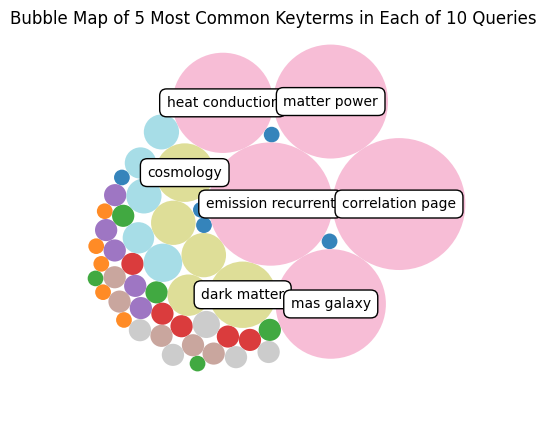

In [106]:
# Setting up figures
fig, ax = helper.plt.subplots(figsize=(5,5))
ax.set_title(f"Bubble Map of {n} Most Common Keyterms in Each of {len(unique_queries)-1} Queries")
ax.axis('off')

# Calculate boundaries of graph
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
helper.plt.xlim(-lim, lim)
helper.plt.ylim(-lim, lim)

# Setting up color/label scheme
norm = TextNorm(queries)
cmap = helper.cm.get_cmap('tab20')
label_color_dict = {}

# Plotting
for circle, annotation, label in zip(circles, keys, queries):
    # Setting up color/label scheme
    normalized_value = norm([label])[0]
    if label not in label_color_dict:
        color = cmap(normalized_value)
        color = helper.mcolors.to_rgba(color)[:3]
        label_color_dict[label] = color
    color = label_color_dict[label]

    # Graphing Circles
    x, y, r = circle
    ax.add_patch(helper.plt.Circle((x, y), r, alpha=0.9, linewidth=2, facecolor=color, label=label))
    if r > 0.15:
        helper.plt.annotate(annotation, (x, y), va='center', ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5))

print(label_color_dict)
print(color)

In [103]:
test = XForce_Grapher()
test.load_nlp_summary()
df = test.get_nlp_summary()
df.head()

Dynamic load disabled in demo mode due to 11hr+ runtime. All functions are ran on database snapshot.


,source,query,published,url,title,abstract,title_char_count,title_word_count,title_keywords,abstract_char_count,abstract_word_count,abstract_keywords
0,arxiv,radiation,2023-06-27T17:54:29Z,http://arxiv.org/abs/2306.15659,cascade emission neutrino coincident disruptio...,association disruption event tde energy neutri...,84,9,"[('emission neutrino', 0.6799), ('neutrino coi...",985,142,"[('neutrino emission', 0.6179), ('neutrino pro..."
1,arxiv,radiation,2023-06-27T17:30:58Z,http://arxiv.org/abs/2306.15639,radiation momentum dipole source magneto biref...,investigate radiation momentum dipole ga field...,99,14,"[('magneto birefringent', 0.7302), ('momentum ...",383,59,"[('radiation momentum', 0.6846), ('momentum di..."
2,arxiv,radiation,2023-06-27T15:11:30Z,http://arxiv.org/abs/2306.15542,view mas star region sir source nir,star impact surrounding formation end life for...,135,19,"[('star region', 0.6698), ('view mas', 0.6171)...",1907,289,"[('protostar observe', 0.5963), ('radiation pr..."
3,arxiv,radiation,2023-06-27T13:52:37Z,http://arxiv.org/abs/2306.15475,horizon,particle field property horizon region spaceti...,50,5,"[('horizon', 1.0)]",794,115,"[('horizon quantum', 0.6515), ('particle field..."
4,arxiv,radiation,2023-06-27T12:05:01Z,http://arxiv.org/abs/2306.15405,intensity dependence ratchet terahertz laser r...,report observation intensity dependence terahe...,149,20,"[('graphene grating', 0.7097), ('bilayer graph...",1920,282,"[('graphene grating', 0.568), ('graphene', 0.5..."


In [104]:
df[df["query"] == "heavy ions"]

,source,query,published,url,title,abstract,title_char_count,title_word_count,title_keywords,abstract_char_count,abstract_word_count,abstract_keywords


# DEV

In [25]:
def graph_pub_freq(country_mode: int=1) -> None:
    """
    # TODO
    # COOP IDEA: Add country mode, which is only available in Scopus.

    Graphs the publishing frequency of papers in the database.

    country_mode -> int
        0: graphs the bars of the bar chart as normal bars
        1: graphs the bars of the bar chart as stacked bar charts corresponding to country of publishing institution

    Returns -> None
        Shows matplotlib graph of the published frequency
    
    Example
        grapher = XForce_Grapher()
        grapher.graph_pub_freq(country_mode=1)
    """
    # Input Error Handling
    country_mode_options = {0,1}
    if country_mode not in country_mode_options:
        print(f"{country_mode} invalid, must be {country_mode_options}")
        return None
    else:
        if country_mode == 1:
            print("Only Scopus data returns the country of origin. This graph will be based on only the Scopus entries in the database; if your pre-filter contains no Scopus data, then this graph will be empty.")

    # Load Data
    df = helper.pd.read_csv(helper.RELATIVE_TO_APP_COMPLETE_DB)
    if country_mode == 1:
        df = df[df["source"] == "scopus"]

    # Data Setup
    df["tags"] = df["tags"].apply(lambda x: helper.eval_db_values(x))
    countries = df["tags"].values.tolist()
    # unique_countries = set(countries)
    print(countries)
    dates_extract = df["published"].apply(lambda x: x.split('T')[0])
    dates = [helper.datetime(int(i.split("-")[0]), int(i.split("-")[1]), int(i.split("-")[2])) for i in dates_extract]

    sorted_by_country_data = []
    for country in unique_countries:
        country_data = []
        for c, d in zip(countries, dates):
            if c == country:
                country_data.append(c, d)
        sorted_by_country_data.append(country_data)

    # print(sorted_by_country_data)

    title_sources = set(df["source"].values.tolist())
    title_queries = set(df["query"].values.tolist())

    
    # Graph
    helper.plt.title(f"Source: {title_sources}, Query: {title_queries}")
    helper.plt.suptitle(f"Publish Frequency within {len(dates)} Most Recent Papers")
    helper.plt.xlabel("Publish Dates")
    helper.plt.ylabel("Frequency")
    helper.plt.grid("True")
    helper.plt.xticks(rotation=45)
    helper.plt.hist(dates, 25, alpha=.75)
    helper.plt.tight_layout()
    helper.plt.savefig(f"../../images/pub_freq/pub_freq_{'_'.join(title_sources)}_{'_'.join(title_queries)}.png")
    helper.plt.show()

    # Return
    return f"../../images/pub_freq/pub_freq_{'_'.join(title_sources)}_{'_'.join(title_queries)}.png"

In [26]:
graph_pub_freq(1)

Only Scopus data returns the country of origin. This graph will be based on only the Scopus entries in the database; if your pre-filter contains no Scopus data, then this graph will be empty.
[{'country': 'India', 'school': 'Amrita University, Amritapuri Campus'}, {'country': 'China', 'school': 'Tsinghua University'}, {'country': 'China', 'school': 'Central South University'}, {'country': 'China', 'school': 'Kunming University of Science and Technology'}, {'country': 'China', 'school': 'Nanjing Forestry University'}, {'country': 'China', 'school': 'State Key Laboratory of Natural Medicines'}, {'country': 'China', 'school': 'Northeast Normal University'}, {'country': 'China', 'school': 'Zhejiang Gongshang University'}, {'country': 'China', 'school': 'Southeast University'}, {'country': 'China', 'school': 'Tsinghua University'}, {'country': 'China', 'school': 'Guangdong Institute of Eco-Environment and Soil Science'}, {'country': 'China', 'school': 'Guangxi University'}, {'country': 'Chi

NameError: name 'unique_countries' is not defined

In [95]:
countries = ["US", "UK", "China", "Germany", "Switzerland", "Other"]
helper.plt.suptitle(f"Distribution of Country Publishing")
helper.plt.title(f"Query: {df['query'][0]}")
helper.plt.grid("True")
values = sorted(big_counts[0], reverse=True)
helper.plt.pie(values, labels=countries)
helper.plt.legend(loc='upper left', bbox_to_anchor=(1,1))
helper.plt.show()

NameError: name 'df' is not defined

<Figure size 640x480 with 0 Axes>